In [126]:
!pip install jinja2

  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)



[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [141]:
import openml
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_randfloat
import matplotlib.pyplot as plt

In [2]:
def prepare_dataset(id, class_col) :
    dataset = openml.datasets.get_dataset(id)
    X, y, _, _ = dataset.get_data(dataset_format="dataframe")
    y = X[class_col]
    X = X.drop(class_col, axis=1)
    return train_test_split(X, y,test_size=0.2, random_state=42)

num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale',MinMaxScaler())])

cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot',OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline,make_column_selector( dtype_include= [np.object_, 'category']))
    ],
    remainder='drop',
    n_jobs=-1)

In [3]:
# tune one dataset with array of iterations

def tune(pipeline, grid, iters, X_train, y_train):
    model_random = []
    idx = 0
    for i in iters:
        model_random.append(RandomizedSearchCV(estimator = pipeline, param_distributions = grid, n_iter = i, cv = 5, verbose=0, random_state=42, n_jobs = -1))
        model_random[idx].fit(X_train, y_train)
        idx += 1
    return model_random

In [4]:
# tune all datasets with the same value of iterations

dataset_ids = [1471, 4534, 1053, 1046]
dataset_targets = ['Class', 'Result', 'defects', 'state']

def all_tune(pipeline, grid, iters):
    model_random = []
    idx = 0
    for i in range(4):
        X_train, X_test, y_train, y_test = prepare_dataset(dataset_ids[i], dataset_targets[i])
        model_random.append(RandomizedSearchCV(estimator = pipeline, param_distributions = grid, n_iter = iters, cv = 5, verbose=0, random_state=42, n_jobs = -1))
        model_random[idx].fit(X_train, y_train)
        idx += 1
    return model_random

In [5]:
# returns array of best accuracy for each value of iterations

def best_accuracy_array(models_tuned):
    accuracy_array = []
    for model in models_tuned:
        accuracy_array.append(model.best_score_)
    return accuracy_array
    

In [6]:
# returns array of best hyperparameters for each value of iterations

def best_params_array(models_tuned):
    hyper_array = []
    for model in models_tuned:
        hyper_array.append(model.best_params_)
    return hyper_array

In [7]:
# create accuracy dataframe from tuned models with the same configurations

def tuned_dataframe(models_tuned):
    for i in range(len(models_tuned)):
        if i == 0:
            df = pd.DataFrame.from_dict(models_tuned[i].cv_results_)
            df = df[['params', 'mean_test_score']]
        else:
            df2 = pd.DataFrame.from_dict(models_tuned[i].cv_results_)
            df = df.join(df2['mean_test_score'])
        df = df.rename(columns={'mean_test_score': 'dataset_' + str(i + 1) + '_accuracy'})
    return df

# Random forest

## Prepare pipeline

In [8]:
from sklearn.ensemble import RandomForestClassifier
rf_pipeline = Pipeline([('preprocessing', col_trans), 
                               ('model', RandomForestClassifier())])

## Prepare grid

In [98]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 7)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 25, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'model__n_estimators': n_estimators,
               'model__max_features': max_features,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf,
               'model__bootstrap': bootstrap}

In [99]:
print(random_grid)

{'model__n_estimators': [50, 75, 100, 125, 150, 175, 200], 'model__max_features': ['log2', 'sqrt', None], 'model__max_depth': [5, 10, 15, 20, 25, None], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4], 'model__bootstrap': [True, False]}


## Tuning dataset 1

In [10]:
X_train, X_test, y_train, y_test = prepare_dataset(1471, 'Class')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [206]:
rf_random = tune(rf_pipeline, random_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [207]:
best_accuracy_array(rf_random)

[0.911298451110633, 0.9290721986233488, 0.928154489160421, 0.9212282604229131, 0.9308245281560215, 0.9288221294982669, 0.9294060187922717]

In [208]:
best_params_array(rf_random)

[{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 25, 'model__bootstrap': True}, {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 175, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 25, 'model__bootstrap': False}, {'model__n_estimators': 75, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__m

## Tuning dataset 2

In [209]:
X_train, X_test, y_train, y_test = prepare_dataset(4534, 'Result')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [210]:
rf_random = tune(rf_pipeline, random_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [211]:
best_accuracy_array(rf_random)

[0.9626866292022745, 0.9687920291393505, 0.9701489196800605, 0.9667569171426452, 0.9707144665928291, 0.9711666355458128, 0.9704880943550181]

In [212]:
best_params_array(rf_random)

[{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 25, 'model__bootstrap': True}, {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 125, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 15, 'model__bootstrap': False}, {'model__n_estimators': 75, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20, 'model__bootstrap': True}, {'model__n_estimators': 50, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'sqrt', 'model__max_depth': 25, 'model__bootstrap': False}, {'model__n_estimators': 75, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth

## Tuning dataset 3

In [213]:
X_train, X_test, y_train, y_test = prepare_dataset(1053, 'defects')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [214]:
rf_random = tune(rf_pipeline, random_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [215]:
best_accuracy_array(rf_random)

[0.8214280297360016, 0.8224615226346946, 0.8230352457216414, 0.8208540428683253, 0.8238391174951911, 0.8217722635881698, 0.8221170250017968]

In [216]:
best_params_array(rf_random)

[{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 25, 'model__bootstrap': True}, {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': 25, 'model__bootstrap': True}, {'model__n_estimators': 175, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 175, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 175, 'model__min_samples_split': 5, 'model__min_samples_leaf': 4, 'model__max_features': 'sqrt', 'model__

## Tuning dataset 4

In [217]:
X_train, X_test, y_train, y_test = prepare_dataset(1046, 'state')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [218]:
rf_random = tune(rf_pipeline, random_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [219]:
best_accuracy_array(rf_random)

[0.9468481441114374, 0.9506273781218606, 0.9499036791961286, 0.9500645155451434, 0.9501450306869031, 0.9511098871689054, 0.9503861882431732]

In [220]:
best_params_array(rf_random)

[{'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': 25, 'model__bootstrap': True}, {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 2, 'model__max_features': 'sqrt', 'model__max_depth': None, 'model__bootstrap': False}, {'model__n_estimators': 75, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20, 'model__bootstrap': True}, {'model__n_estimators': 75, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 20, 'model__bootstrap': True}, {'model__n_estimators': 75, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': None, 'model__max_depth': 

## Tuning all datasets

In [100]:
models = all_tune(rf_pipeline, random_grid, 50)

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
E:\Python\repo\WzTUM\imageclassification\lib\site-packag

In [196]:
df1 = tuned_dataframe(models)
df1['mean'] = df1.mean(numeric_only=True, axis=1)
df1

,params,dataset_1_accuracy,dataset_2_accuracy,dataset_3_accuracy,dataset_4_accuracy,mean
0,"{'model__n_estimators': 200, 'model__min_sampl...",0.770695,0.929670,0.813735,0.934143,0.862061
1,"{'model__n_estimators': 150, 'model__min_sampl...",0.712951,0.925599,0.809830,0.935349,0.845932
2,"{'model__n_estimators': 100, 'model__min_sampl...",0.824767,0.951832,0.762286,0.921035,0.864980
3,"{'model__n_estimators': 100, 'model__min_sampl...",0.912133,0.961669,0.818327,0.948296,0.910106
4,"{'model__n_estimators': 100, 'model__min_sampl...",0.909046,0.958955,0.820050,0.946848,0.908725
5,"{'model__n_estimators': 125, 'model__min_sampl...",0.908461,0.962799,0.819361,0.947974,0.909649
6,"{'model__n_estimators': 125, 'model__min_sampl...",0.913719,0.964156,0.817868,0.949341,0.911271
7,"{'model__n_estimators': 200, 'model__min_sampl...",0.860147,0.953867,0.816605,0.945883,0.894126
8,"{'model__n_estimators': 75, 'model__min_sample...",0.906459,0.957033,0.817408,0.947893,0.907198
9,"{'model__n_estimators': 200, 'model__min_sampl...",0.824433,0.950022,0.772277,0.924734,0.867867


In [198]:
# calculate tunability vector
mean_max1 = [df1['mean'].idxmax(), df1['mean'].max()]
tunability1 = mean_max1[1] - df1['mean']

In [201]:
df1['params'][mean_max1[0]]

{'model__n_estimators': 75, 'model__min_samples_split': 5, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None, 'model__bootstrap': False}

# SVM

## Prepare pipeline

In [107]:
from sklearn.svm import SVC
svc_pipeline = Pipeline([('preprocessing', col_trans), 
                               ('model', SVC())])

## Prepare grid

In [135]:
svc_grid = {'model__C': [0.1, 1, 10, 100, 1000],  
              'model__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'model__kernel': ['rbf', 'linear', 'sigmoid']}  

## Tuning dataset 1

In [221]:
X_train, X_test, y_train, y_test = prepare_dataset(1471, 'Class')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [222]:
svc_random = tune(svc_pipeline, svc_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluation

In [223]:
best_accuracy_array(svc_random)

[0.5567423246782462, 0.6086440827885162, 0.6086440827885162, 0.6086440827885162, 0.6086440827885162, 0.6086440827885162, 0.6086440827885162]

In [224]:
best_params_array(svc_random)

[{'model__kernel': 'linear', 'model__gamma': 0.1, 'model__C': 0.1}, {'model__kernel': 'linear', 'model__gamma': 1, 'model__C': 1000}, {'model__kernel': 'linear', 'model__gamma': 1, 'model__C': 1000}, {'model__kernel': 'linear', 'model__gamma': 1, 'model__C': 1000}, {'model__kernel': 'linear', 'model__gamma': 1, 'model__C': 1000}, {'model__kernel': 'linear', 'model__gamma': 1, 'model__C': 1000}, {'model__kernel': 'linear', 'model__gamma': 1, 'model__C': 1000}]

## Tuning dataset 2

In [225]:
X_train, X_test, y_train, y_test = prepare_dataset(4534, 'Result')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [226]:
svc_random = tune(svc_pipeline, svc_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [227]:
best_accuracy_array(svc_random)

[0.9381500528201888, 0.9681139355772748, 0.9683398601863671, 0.9683398601863671, 0.9683398601863671, 0.9683398601863671, 0.9683398601863671]

In [228]:
best_params_array(svc_random)

[{'model__kernel': 'linear', 'model__gamma': 0.1, 'model__C': 0.1}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 1000}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 10}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 10}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 10}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 10}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 10}]

## Tuning dataset 3

In [229]:
X_train, X_test, y_train, y_test = prepare_dataset(1053, 'defects')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [230]:
svc_random = tune(svc_pipeline, svc_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [231]:
best_accuracy_array(svc_random)

[0.806385010396258, 0.8096003656000912, 0.8096003656000912, 0.8114375324367866, 0.8114375324367866, 0.8114375324367866, 0.8114375324367866]

In [232]:
best_params_array(svc_random)

[{'model__kernel': 'linear', 'model__gamma': 0.1, 'model__C': 0.1}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 1000}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 1000}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}]

## Tuning dataset 4

In [233]:
X_train, X_test, y_train, y_test = prepare_dataset(1046, 'state')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [234]:
svc_random = tune(svc_pipeline, svc_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [235]:
best_accuracy_array(svc_random)

[0.8288030233096346, 0.8704564377851645, 0.8704564377851645, 0.8830811538327275, 0.8830811538327275, 0.8830811538327275, 0.8830811538327275]

In [236]:
best_params_array(svc_random)

[{'model__kernel': 'linear', 'model__gamma': 0.1, 'model__C': 0.1}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 1000}, {'model__kernel': 'rbf', 'model__gamma': 0.1, 'model__C': 1000}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}, {'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}]

## Tuning all datasets

In [136]:
models2 = all_tune(svc_pipeline, svc_grid, 50)

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
E:\Python\repo\WzTUM\imageclassification\lib\site-packag

In [143]:
df2 = tuned_dataframe(models2)
df2['mean'] = df2.mean(numeric_only=True, axis=1)
df2

,params,dataset_1_accuracy,dataset_2_accuracy,dataset_3_accuracy,dataset_4_accuracy,mean
0,"{'model__kernel': 'linear', 'model__gamma': 0....",0.556742,0.938150,0.806385,0.828803,0.782520
1,"{'model__kernel': 'rbf', 'model__gamma': 0.1, ...",0.602553,0.968114,0.809600,0.870456,0.812681
2,"{'model__kernel': 'linear', 'model__gamma': 0....",0.556742,0.938150,0.806385,0.828803,0.782520
3,"{'model__kernel': 'rbf', 'model__gamma': 1, 'm...",0.556659,0.571008,0.806615,0.825024,0.689826
4,"{'model__kernel': 'sigmoid', 'model__gamma': 0...",0.556826,0.786069,0.807304,0.754906,0.726276
5,"{'model__kernel': 'linear', 'model__gamma': 1,...",0.608644,0.938376,0.809256,0.832744,0.797255
6,"{'model__kernel': 'linear', 'model__gamma': 0....",0.557076,0.939507,0.807074,0.835559,0.784804
7,"{'model__kernel': 'rbf', 'model__gamma': 0.000...",0.556659,0.554274,0.806270,0.668623,0.646457
8,"{'model__kernel': 'rbf', 'model__gamma': 0.001...",0.557994,0.950475,0.807074,0.838212,0.788439
9,"{'model__kernel': 'linear', 'model__gamma': 0....",0.608644,0.938376,0.809256,0.832744,0.797255


In [147]:
# calculate tunability vector
mean_max2 = [df2['mean'].idxmax(), df2['mean'].max()]
tunability2 = mean_max2[1] - df2['mean']

In [202]:
# best configuration 
df2['params'][mean_max2[0]]

{'model__kernel': 'rbf', 'model__gamma': 1, 'model__C': 100}

In [203]:
# best mean accuracy
mean_max2[1]

0.8133374006292702

# XGBoost

## Prepare grid

In [111]:
xgb_grid = {
    'model__gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,5],
    'model__learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3],
    'model__max_depth': [3,5,6,7,8,9,10],
    'model__n_estimators': [50,75,100,125,150,175,200],
    'model__reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
    'model__reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
}

## Prepare pipeline

In [112]:
import xgboost as xgb
xgb_pipeline = Pipeline([('preprocessing', col_trans), 
                               ('model', xgb.XGBClassifier())])

## Tuning dataset 1

In [237]:
X_train, X_test, y_train, y_test = prepare_dataset(1471, 'Class')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [238]:
xgb_random = tune(xgb_pipeline, xgb_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [239]:
best_accuracy_array(xgb_random)

[0.9031209713310252, 0.9058751792550928, 0.927236849344931, 0.9305741107937511, 0.9395027730127323, 0.9395027730127323, 0.9395027730127323]

In [240]:
best_params_array(xgb_random)

[{'model__reg_lambda': 1.6, 'model__reg_alpha': 12.8, 'model__n_estimators': 50, 'model__max_depth': 9, 'model__learning_rate': 0.25, 'model__gamma': 0.1}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 3.2, 'model__n_estimators': 75, 'model__max_depth': 6, 'model__learning_rate': 0.2, 'model__gamma': 0.1}, {'model__reg_lambda': 51.2, 'model__reg_alpha': 0.1, 'model__n_estimators': 175, 'model__max_depth': 10, 'model__learning_rate': 0.15, 'model__gamma': 0}, {'model__reg_lambda': 0.8, 'model__reg_alpha': 0.8, 'model__n_estimators': 175, 'model__max_depth': 5, 'model__learning_rate': 0.3, 'model__gamma': 0.4}, {'model__reg_lambda': 6.4, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__max_depth': 8, 'model__learning_rate': 0.3, 'model__gamma': 0.1}, {'model__reg_lambda': 6.4, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__max_depth': 8, 'model__learning_rate': 0.3, 'model__gamma': 0.1}, {'model__reg_lambda': 6.4, 'model__reg_alpha': 0.1, 'model__n_estimators':

## Tuning dataset 2

In [241]:
X_train, X_test, y_train, y_test = prepare_dataset(4534, 'Result')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [242]:
xgb_random = tune(xgb_pipeline, xgb_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [243]:
best_accuracy_array(xgb_random)

[0.9535276979861823, 0.9614427329395905, 0.9673222082675746, 0.9673222082675746, 0.9716187405518367, 0.9716187405518367, 0.9716187405518367]

In [244]:
best_params_array(xgb_random)

[{'model__reg_lambda': 1.6, 'model__reg_alpha': 12.8, 'model__n_estimators': 50, 'model__max_depth': 9, 'model__learning_rate': 0.25, 'model__gamma': 0.1}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 3.2, 'model__n_estimators': 75, 'model__max_depth': 6, 'model__learning_rate': 0.2, 'model__gamma': 0.1}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.4, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.15, 'model__gamma': 0.4}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.4, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.15, 'model__gamma': 0.4}, {'model__reg_lambda': 6.4, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__max_depth': 8, 'model__learning_rate': 0.3, 'model__gamma': 0.1}, {'model__reg_lambda': 6.4, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__max_depth': 8, 'model__learning_rate': 0.3, 'model__gamma': 0.1}, {'model__reg_lambda': 6.4, 'model__reg_alpha': 0.1, 'model__n_estimators'

## Tuning dataset 3

In [245]:
X_train, X_test, y_train, y_test = prepare_dataset(1053, 'defects')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [246]:
xgb_random = tune(xgb_pipeline, xgb_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [247]:
best_accuracy_array(xgb_random)

[0.816146941693248, 0.8167200053283707, 0.8191312249779248, 0.8191312249779248, 0.8191312249779248, 0.8191312249779248, 0.8191312249779248]

In [248]:
best_params_array(xgb_random)

[{'model__reg_lambda': 1.6, 'model__reg_alpha': 12.8, 'model__n_estimators': 50, 'model__max_depth': 9, 'model__learning_rate': 0.25, 'model__gamma': 0.1}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 3.2, 'model__n_estimators': 75, 'model__max_depth': 6, 'model__learning_rate': 0.2, 'model__gamma': 0.1}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.4, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.15, 'model__gamma': 0.4}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.4, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.15, 'model__gamma': 0.4}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.4, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.15, 'model__gamma': 0.4}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.4, 'model__n_estimators': 100, 'model__max_depth': 7, 'model__learning_rate': 0.15, 'model__gamma': 0.4}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.4, 'model__n_estimator

## Tuning dataset 4

In [249]:
X_train, X_test, y_train, y_test = prepare_dataset(1046, 'state')

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(


In [250]:
xgb_random = tune(xgb_pipeline, xgb_grid, [1, 10, 20, 30, 40, 45, 50], X_train, y_train)

## Evaluate

In [251]:
best_accuracy_array(xgb_random)

[0.9441943443526919, 0.9476521965668422, 0.9503054468444916, 0.9506271841873563, 0.9506271841873563, 0.9506271841873563, 0.9506271841873563]

In [252]:
best_params_array(xgb_random)

[{'model__reg_lambda': 1.6, 'model__reg_alpha': 12.8, 'model__n_estimators': 50, 'model__max_depth': 9, 'model__learning_rate': 0.25, 'model__gamma': 0.1}, {'model__reg_lambda': 0, 'model__reg_alpha': 1.6, 'model__n_estimators': 175, 'model__max_depth': 10, 'model__learning_rate': 0.25, 'model__gamma': 5}, {'model__reg_lambda': 0.2, 'model__reg_alpha': 0.8, 'model__n_estimators': 125, 'model__max_depth': 7, 'model__learning_rate': 0.3, 'model__gamma': 0.8}, {'model__reg_lambda': 0.8, 'model__reg_alpha': 0.8, 'model__n_estimators': 175, 'model__max_depth': 5, 'model__learning_rate': 0.3, 'model__gamma': 0.4}, {'model__reg_lambda': 0.8, 'model__reg_alpha': 0.8, 'model__n_estimators': 175, 'model__max_depth': 5, 'model__learning_rate': 0.3, 'model__gamma': 0.4}, {'model__reg_lambda': 0.8, 'model__reg_alpha': 0.8, 'model__n_estimators': 175, 'model__max_depth': 5, 'model__learning_rate': 0.3, 'model__gamma': 0.4}, {'model__reg_lambda': 0.8, 'model__reg_alpha': 0.8, 'model__n_estimators': 1

## Tuning all datasets

In [113]:
models3 = all_tune(xgb_pipeline, xgb_grid, 50)

E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
E:\Python\repo\WzTUM\imageclassification\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
E:\Python\repo\WzTUM\imageclassification\lib\site-packag

In [144]:
df3 = tuned_dataframe(models3)
df3['mean'] = df3.mean(numeric_only=True, axis=1)
df3

,params,dataset_1_accuracy,dataset_2_accuracy,dataset_3_accuracy,dataset_4_accuracy,mean
0,"{'model__reg_lambda': 1.6, 'model__reg_alpha':...",0.903121,0.953528,0.816147,0.944194,0.904247
1,"{'model__reg_lambda': 12.8, 'model__reg_alpha'...",0.905625,0.953302,0.816491,0.943390,0.904702
2,"{'model__reg_lambda': 1.6, 'model__reg_alpha':...",0.843625,0.942786,0.807074,0.936957,0.882611
3,"{'model__reg_lambda': 51.2, 'model__reg_alpha'...",0.873165,0.951606,0.815343,0.943069,0.895795
4,"{'model__reg_lambda': 0.2, 'model__reg_alpha':...",0.905875,0.961443,0.816720,0.947491,0.907882
5,"{'model__reg_lambda': 0, 'model__reg_alpha': 5...",0.827354,0.939620,0.806500,0.933339,0.876703
6,"{'model__reg_lambda': 1.6, 'model__reg_alpha':...",0.813417,0.933401,0.811553,0.932856,0.872807
7,"{'model__reg_lambda': 0, 'model__reg_alpha': 1...",0.897029,0.955563,0.815457,0.947652,0.903925
8,"{'model__reg_lambda': 12.8, 'model__reg_alpha'...",0.868658,0.948327,0.813275,0.940013,0.892568
9,"{'model__reg_lambda': 0.2, 'model__reg_alpha':...",0.837867,0.945952,0.811323,0.939048,0.883548


In [145]:
# calculate tunability vector
mean_max3 = [df3['mean'].idxmax(), df3['mean'].max()]
tunability3 = mean_max3[1] - df3['mean']

In [204]:
# best configuration 
df3['params'][mean_max3[0]]

{'model__reg_lambda': 6.4, 'model__reg_alpha': 0.1, 'model__n_estimators': 200, 'model__max_depth': 8, 'model__learning_rate': 0.3, 'model__gamma': 0.1}

In [205]:
mean_max3[1]

0.9177681913688276

# Results

In [154]:
tunability_df = pd.DataFrame()
tunability_df['RF tunability'] = tunability1
tunability_df['SVC tunability'] = tunability2
tunability_df['XGB tunability'] = tunability3

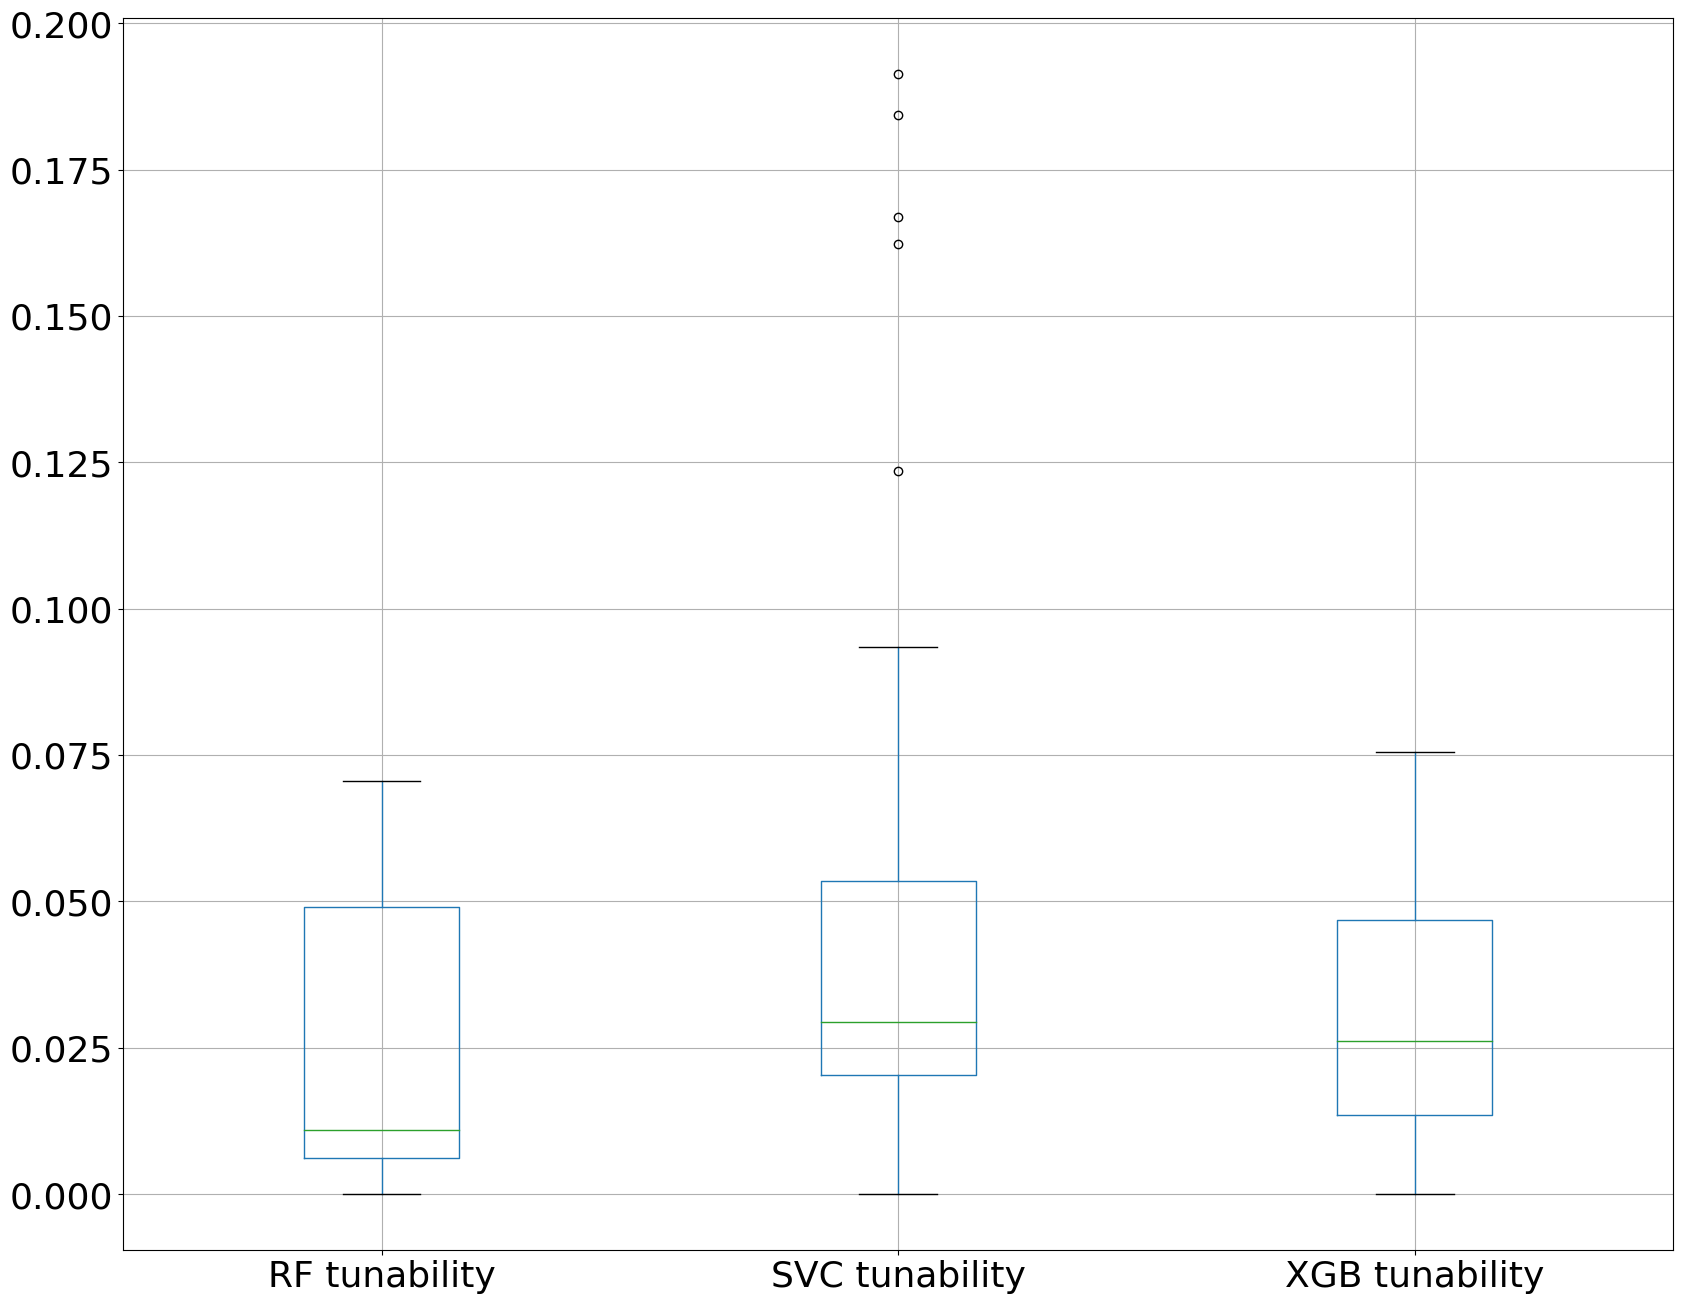

In [200]:
plot = tunability_df.boxplot(figsize=(20, 16), fontsize=26).get_figure()

In [169]:
plot.savefig('random_tun.png')